# CISC 452 Assignment 2 - Backpropagation (100 points)  

Please put your name and student id

    FirstName LastName, #12345678

- The notebook file has clearly marked blocks where you are expected to write code. Do not write or modify any code outside of these blocks.
- Do not add or delete cells from the notebook.
- Run all cells, and do not clear out the outputs, before submitting. You will only get credit for code that has been run.
- Make sure to run all the cells from beginning before the submission

## [Part 1 (60 points)](#Part-1)  

### Build Model1 (50 points)  
Use Pytorch to implement a three-layer Neural Network (input layer - hidden layer - output layer) and update the weights with backpropagation  
- 1. Implement forward and calculate the output (10 points)  
- 2. Calculate errors and loss (10 points)  
- 3. Update the weights with backpropagation (20 points)  
- 4. Predict function (5 points)  
- 5. Activation function (Sigmoid function) (5 points)  

### Evaluate Model1 (10 points)  
Use the predict function to predict the labels with the test dataset (5 points)  
Evaluate the prediction results (5 points)   
- Evaluation matrices include confusion matrix, accuracy, recall score, precision and F1 score

## [Part 2 (40 points)](#Part-2)  

Use another machine learning framework (**scikit-learn, Tensorflow and Pytorch**) to build MLP
e.g. 
  1. https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
  2. https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
  3. https://pytorch.org/tutorials/beginner/examples_nn/polynomial_nn.html#sphx-glr-beginner-examples-nn-polynomial-nn-py
  
### Build Model2-1 (15 points)  
Implement model 2-1 with the same hidden nodes and optimization function as the model in Part 1  
Train and validate model. Use the best model on validation dataset to test on the test dataset  

### Evaluate Model2-1 (5 points)
Evaluate the prediction results (5 points)   
- Evaluation matrices include confusion matrix, accuracy, recall score, precision and F1 score

### Build Model2-2 (15 points)  
Add one more hidden layer (2 hidden layers in total) to the model  
Describe Model 2-2 (number of hidden nodes)  
Train and validate model. Use the best model on validation dataset to test on the test dataset  

### Evaluate Model2-2 (5 points)
Evaluate the prediction results (5 points)   
- Evaluation matrices include confusion matrix, accuracy, recall score, precision and F1 score

In [ ]:
# Donghao Wang 20119632
import torch
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST

In [ ]:
# make sure you are using GPU, or you can go to Edit - Notebook settings to select under the Hardware accelerator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# build the dataset (train, validation and test)

def load_MNIST(n_val=10000, n_sample=1000, sample=False):
    n_val = n_val
    n_sample = n_sample
    train = MNIST(root = '.', train = True, download = True)
    test = MNIST(root = '.', train = False, download = True)
    
    # data preprocessing
    x_train, x_test = train.data/255, test.data/255
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    y_train = torch.nn.functional.one_hot(train.targets)
    y_test = torch.nn.functional.one_hot(test.targets)

    data_dict = {}
    if sample:
        data_dict['x_train'] = x_train[:-n_val][:n_sample]
        data_dict['y_train'] = y_train[:-n_val][:n_sample]
        data_dict['x_val'] = x_train[-n_val:][:n_sample//10]
        data_dict['y_val'] = y_train[-n_val:][:n_sample//10]
        data_dict['x_test'] = x_test[:n_sample//10]
        data_dict['y_test'] = y_test[:n_sample//10]
    else:
        data_dict['x_train'] = x_train[:-n_val]
        data_dict['y_train'] = y_train[:-n_val]
        data_dict['x_val'] = x_train[-n_val:]
        data_dict['y_val'] = y_train[-n_val:]
        data_dict['x_test'] = x_test
        data_dict['y_test'] = y_test
    return data_dict

In [ ]:
# you can start with a small sample dataset by setting sample=True
data_dict = load_MNIST(sample=False)
print('Train data shape:', data_dict['x_train'].shape)
print('Train labels shape:', data_dict['y_train'].shape)
print('Validation data shape:', data_dict['x_val'].shape)
print('Validation labels shape:', data_dict['y_val'].shape)
print('Test data shape:', data_dict['x_test'].shape)
print('Test labels shape:', data_dict['y_test'].shape)

Train data shape: torch.Size([50000, 784])
Train labels shape: torch.Size([50000, 10])
Validation data shape: torch.Size([10000, 784])
Validation labels shape: torch.Size([10000, 10])
Test data shape: torch.Size([10000, 784])
Test labels shape: torch.Size([10000, 10])


In [ ]:
# check the data distribution if you use a sample dataset to avoid imbanlance dataset
for i in range(10):
    print(torch.sum(torch.argmax(data_dict['y_test'], dim=1)==i))

tensor(980)
tensor(1135)
tensor(1032)
tensor(1010)
tensor(982)
tensor(892)
tensor(958)
tensor(1028)
tensor(974)
tensor(1009)


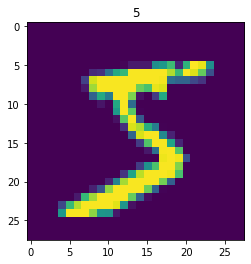

In [ ]:
# plot an example
plt.imshow(data_dict['x_train'][0].reshape(28, 28))
plt.title(data_dict['y_train'][0].argmax().item())
plt.show()

In [ ]:
# TODO: use the predict function to predict the lables with the test dataset
# TODO: evaluate the prediction results (accuracy, recall score, precision and F1 score)
####################################################################################################
# enter code here to calculate the hidden layer output and output layer output
# Write a function to analyze the result
import sklearn.metrics
def evaluator(test_y, pred_y):
    print("Confusion matrix:")
    print(sklearn.metrics.confusion_matrix(test_y,pred_y))
    print("Accuracy:")
    print(sklearn.metrics.accuracy_score(test_y,pred_y))
    print("Recall:")
    print(sklearn.metrics.recall_score(test_y,pred_y,average='macro'))
    print("Precision:")
    print(sklearn.metrics.precision_score(test_y,pred_y,average='macro'))
    print("F1 score:")
    print(sklearn.metrics.f1_score(test_y,pred_y,average='macro'))
    return 0

####################################################################################################

## Part 1

In [ ]:
class NN(object):
    def __init__(self, hidden_size, device, dtype=torch.float32):
        self.hidden_size = hidden_size
        self.device = device
        self.dtype = dtype
        self.history = {}
        self.history['train_acc'], self.history['val_acc'], self.history['loss'] = [], [], []
        
    def sigmoid(self, x):
        ####################################################################################################
        # 5. enter code here to implement the activation function
        return torch.sigmoid(x)
        ####################################################################################################

    def train(self, x, y, x_val, y_val, learning_rate=0.001, n_iters=100, batch_size=200, verbose=0):
        n_train = x.shape[0]
        n_val = x_val.shape[0]
        input_size = x.shape[1]
        num_classes = y.shape[1]
        
        self.params = {}
        ####################################################################################################
        # You can change the initialzation here if you want
        self.W1 = torch.randn(input_size, self.hidden_size, dtype=self.dtype, device=self.device) * 0.01
        self.b1 = torch.zeros(self.hidden_size, dtype=self.dtype, device=self.device)
        self.W2 = torch.randn(self.hidden_size, num_classes, dtype=self.dtype, device=self.device) * 0.01
        self.b2 = torch.zeros(num_classes, dtype=self.dtype, device=self.device)
        ####################################################################################################


        # TODO: train the weights with the input data and labels
        for i in range(n_iters):
            loss = 0
            data = getBatch(x, y, batch_size)
            for x_batch, y_batch in data:
                # forward
                ####################################################################################################
                # 1. enter code here to calculate the hidden layer output and output layer output
                hidden=self.sigmoid(torch.matmul(x_batch,self.W1)+self.b1)
                ####################################################################################################
                output=self.sigmoid(torch.matmul(hidden,self.W2)+self.b2)
                ####################################################################################################
                # 2. enter code here to calculate the hidden layer error, output layer error and loss
                output_error = y_batch-output
                hidden_error = torch.matmul(output_error,torch.transpose(self.W2,0,1))#outputerror*hidden output weight
                # loss
                loss =torch.mean(torch.square(output_error))
                ####################################################################################################

               

                # backward
                ####################################################################################################
                # 3. enter code here to update the weights with the errors
                #calculate theta*x first
                #update weights
                self.W1+=learning_rate*torch.matmul(torch.transpose(x_batch,0,1),hidden_error)
                self.W2+=learning_rate*torch.matmul(torch.transpose(hidden,0,1),output_error)
                #update the bias using the weight change of each individual neruon
                self.b1+=learning_rate*torch.mean(torch.transpose(torch.matmul(torch.transpose(x_batch,0,1),hidden_error),0,1),1)
                self.b2+=learning_rate*torch.mean(torch.transpose(torch.matmul(torch.transpose(hidden,0,1),output_error),0,1),1)
                ####################################################################################################

            # calculate the accuracy
            y_pred = self.predict(x)
            train_acc = torch.sum(torch.argmax(y, dim=1) == torch.argmax(y_pred, dim=1)) / n_train
            self.history['train_acc'].append(train_acc)
            self.history['loss'].append(loss)
            
            y_pred = self.predict(x_val)
            val_acc = torch.sum(torch.argmax(y_val, dim=1) == torch.argmax(y_pred, dim=1)) / n_val
            self.history['val_acc'].append(val_acc)
            if verbose:
                print('epoch %d, loss %.4f, train acc %.3f, validation acc %.3f'
                  % (i + 1, loss, train_acc, val_acc))
                
    def predict(self, x):
        ####################################################################################################
        # 4. enter code here to complete the predict function
        # TODO: use the trained weights to predict labels and return the predicted labels
        hidden_output=self.sigmoid(torch.matmul(x,self.W1)+self.b1)
        y_pred=self.sigmoid(torch.matmul(hidden_output,self.W2)+self.b2)
        ####################################################################################################
        return y_pred

def getBatch(x, y, batch_size):
    n_epoch = x.shape[0] // batch_size
    for i in range(n_epoch):
        x_batch = x[i * batch_size : (i+1) * batch_size]
        y_batch = y[i * batch_size : (i+1) * batch_size]
        yield x_batch, y_batch
    x_batch = x[(i+1) * batch_size:]
    y_batch = y[(i+1) * batch_size:]    
    yield x_batch, y_batch

In [ ]:
####################################################################################################
# enter code here to tune the parameters
# TODO: set your desired hidden size, learning rate, number of iterations and batch size
hidden_size = 300
model = NN(hidden_size, device)
model.train(data_dict['x_train'].to(device),
            data_dict['y_train'].to(device),
            data_dict['x_val'].to(device),
            data_dict['y_val'].to(device), 
            learning_rate=0.01,
            n_iters=10,
            batch_size=32,
            verbose=1)
####################################################################################################

epoch 1, loss 0.0211, train acc 0.905, validation acc 0.917
epoch 2, loss 0.0209, train acc 0.910, validation acc 0.919
epoch 3, loss 0.0201, train acc 0.914, validation acc 0.921
epoch 4, loss 0.0200, train acc 0.916, validation acc 0.921
epoch 5, loss 0.0199, train acc 0.917, validation acc 0.921
epoch 6, loss 0.0209, train acc 0.917, validation acc 0.921
epoch 7, loss 0.0211, train acc 0.918, validation acc 0.922
epoch 8, loss 0.0208, train acc 0.918, validation acc 0.923
epoch 9, loss 0.0205, train acc 0.919, validation acc 0.924
epoch 10, loss 0.0218, train acc 0.920, validation acc 0.925


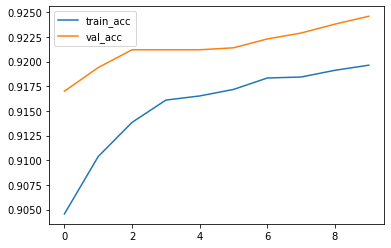

In [ ]:
plt.plot(model.history['train_acc'], label='train_acc')
plt.plot(model.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(data_dict['x_test'].to(device))
evaluator(data_dict['y_test'].argmax(dim=1), torch.argmax(y_pred, dim=1).cpu())

Confusion matrix:
[[ 970    0    1    2    0    1    3    1    2    0]
 [   0 1117    1    3    0    1    4    2    7    0]
 [  20    6  921   13    9    2   10   15   32    4]
 [   5    0   14  927    1   23    0   17   14    9]
 [   1    3    6    2  898    0    6    4   10   52]
 [  17    3    2   46   11  750    6   13   34   10]
 [  20    3    2    1    5   19  901    2    5    0]
 [   3   11   13    5    2    2    0  967    2   23]
 [  18   15    6   20   12   38    8   18  826   13]
 [  17    8    0    7   20   10    0   32    4  911]]
Accuracy:
0.9188
Recall:
0.9171553926753436
Precision:
0.9181807788477878
F1 score:
0.9171957001011691


0

## Part 2

### Model2-1

In [ ]:
####################################################################################################
# enter code here to implement evaluate Model2-1
from sklearn.neural_network import MLPClassifier
Model2_1=MLPClassifier(solver='adam',hidden_layer_sizes=(300,),
                       activation='logistic',learning_rate_init=0.01,max_iter=10,random_state=1,verbose=1,batch_size=32)
Model2_1.fit(data_dict['x_train'],data_dict['y_train'])
prediction_y=Model2_1.predict(data_dict['x_test'])
pred_y=torch.from_numpy(prediction_y)
evaluator(data_dict['y_test'].argmax(dim=1), torch.argmax(pred_y, dim=1).cpu())
####################################################################################################

Iteration 1, loss = 0.48239409
Iteration 2, loss = 0.27721598
Iteration 3, loss = 0.25425254
Iteration 4, loss = 0.24254317
Iteration 5, loss = 0.24325100
Iteration 6, loss = 0.23678251
Iteration 7, loss = 0.23435578
Iteration 8, loss = 0.22958227
Iteration 9, loss = 0.22618977
Iteration 10, loss = 0.23058582


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Confusion matrix:
[[ 976    0    0    0    1    1    1    1    0    0]
 [  18 1106    1    2    0    0    1    1    6    0]
 [  65    0  944    2    0    0    5    5   11    0]
 [  52    0    1  948    0    3    0    1    5    0]
 [  16    0    0    0  957    0    1    0    1    7]
 [  30    0    0    5    0  848    5    2    2    0]
 [  20    3    0    1    3   10  919    0    2    0]
 [  34    2    2    5    1    1    0  980    1    2]
 [  32    0    1    1    5   10    3    1  919    2]
 [  57    2    0    3   15    0    0    7    5  920]]
Accuracy:
0.9517
Recall:
0.9516847911083304
Precision:
0.9583840199237846
F1 score:
0.9528789369264347


0

### Model2-2

In [ ]:
####################################################################################################
# enter code here to implement evaluate Model2-2
# 2 hidden layer, with 300 neurons and 10 neurons, and 1 output layer with 10 neurons
Model2_1=MLPClassifier(solver='adam',hidden_layer_sizes=(300,10,),
                       activation='logistic',learning_rate_init=0.01,max_iter=10,random_state=1,verbose=1,batch_size=32)
Model2_1.fit(data_dict['x_train'],data_dict['y_train'])
prediction_y=Model2_1.predict(data_dict['x_test'])
pred_y=torch.from_numpy(prediction_y)
evaluator(data_dict['y_test'].argmax(dim=1), torch.argmax(pred_y, dim=1).cpu())
####################################################################################################

Iteration 1, loss = 2.00732481
Iteration 2, loss = 0.61086592
Iteration 3, loss = 0.46951035
Iteration 4, loss = 0.42810494
Iteration 5, loss = 0.40681089
Iteration 6, loss = 0.38454249
Iteration 7, loss = 0.38016944
Iteration 8, loss = 0.36225175
Iteration 9, loss = 0.37587302
Iteration 10, loss = 0.37235148


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Confusion matrix:
[[ 963    0    2    3    0    0    6    1    4    1]
 [   4 1119    2    1    1    2    1    1    4    0]
 [  20    7  983    3    1    0    3    7    8    0]
 [  17    0   13  953    0    4    0    5   17    1]
 [  19    0    2    1  938    0    8    1    2   11]
 [  29    3    0   28    2  805    6    0   13    6]
 [  13    3    4    0    7    2  926    0    3    0]
 [  16    6    4    4    5    0    0  990    0    3]
 [  20    0    6    3    3    6    2    3  928    3]
 [  34    4    0    4   16    3    0   23   14  911]]
Accuracy:
0.9516
Recall:
0.950757803503317
Precision:
0.9532939491685728
F1 score:
0.9512239335538071


0